# Pneumonia Classification

## Dataset
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.


  

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

# 1. Data preprocessing and visualization

In [2]:
# Create a list with the filepaths for training and testing
dir_ = Path('./chest_xray/train')
train_file_paths = list(dir_.glob(r'**/*.jpeg'))

dir_ = Path('./chest_xray/test')
test_file_paths = list(dir_.glob(r'**/*.jpeg'))

dir_ = Path('./chest_xray/val')
val_file_paths = list(dir_.glob(r'**/*.jpeg'))

In [3]:
import pandas as pd
from typing import List
from pathlib import Path

def create_image_dataframe(filepaths: List[str]) -> pd.DataFrame:
    """Creates a DataFrame with filepaths and corresponding labels.

    Args:
        filepaths (List[str]): A list of filepaths.

    Returns:
        pd.DataFrame: A DataFrame containing the filepaths and labels.
    """

    labels = [Path(filepath).parent.name for filepath in filepaths]

    filepath_series = pd.Series(filepaths, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath_series, labels_series], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    return df

train_df = create_image_dataframe(train_file_paths)
val_df = create_image_dataframe(val_file_paths)
# Combine train_df and val_df
train_df = pd.concat([train_df,val_df]).reset_index(drop = True)
test_df = create_image_dataframe(test_file_paths)


print(f'Number of pictures in the training set: {train_df.shape[0]}')
print(f'Number of pictures in the test set: {test_df.shape[0]}')
print(f'Number of pictures in the validation set: {val_df.shape[0]}\n')


print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures in the training set: 5216
Number of pictures in the test set: 624
Number of pictures in the validation set: 16

Number of different labels: 2

Labels: ['PNEUMONIA' 'NORMAL']


Filepath      Label
0  chest_xray\train\PNEUMONIA\person1239_virus_20...  PNEUMONIA
1  chest_xray\train\PNEUMONIA\person1875_bacteria...  PNEUMONIA
2  chest_xray\train\NORMAL\NORMAL2-IM-0423-0001.jpeg     NORMAL
3  chest_xray\train\PNEUMONIA\person67_bacteria_3...  PNEUMONIA
4          chest_xray\train\NORMAL\IM-0519-0001.jpeg     NORMAL

C:\Users\narra\AppData\Local\Temp\ipykernel_7896\685399292.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted(vc.index), y=vc, palette="Set2")


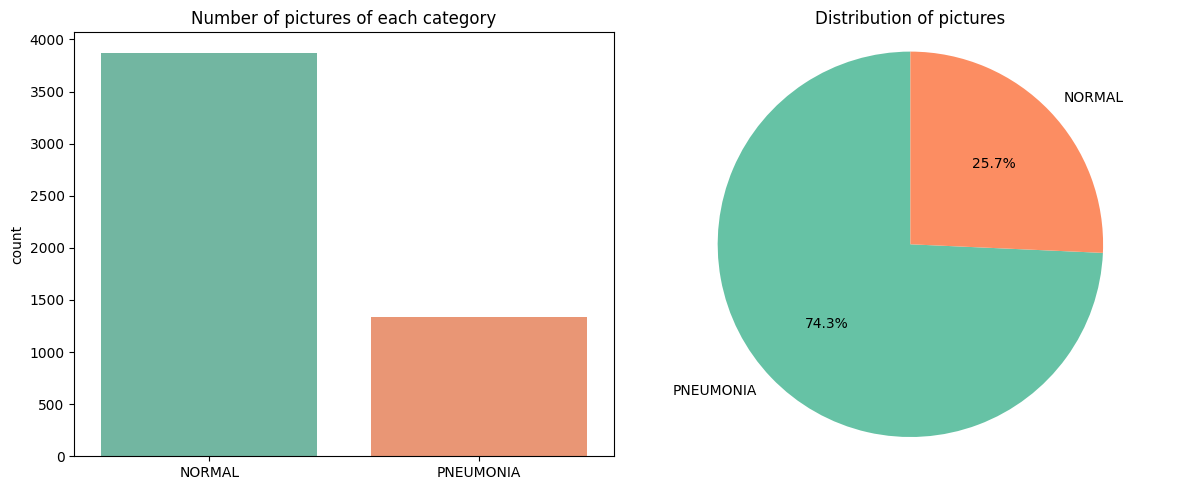

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_category_distribution(df, save_path):
    """Plots and saves a bar plot and a pie chart for the category distribution in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the category data.
        save_path (str): The directory to save the generated images.
    """

    # Display the number of pictures of each category in the DataFrame
    vc = df['Label'].value_counts()

    # Plotting the bar chart
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x=sorted(vc.index), y=vc, palette="Set2")
    plt.title("Number of pictures of each category", fontsize=12)

    # Saving the bar plot
    bar_plot_path = os.path.join(save_path, 'category_distribution_bar.png')
    plt.savefig(bar_plot_path)

    # Plotting the pie chart
    plt.subplot(1, 2, 2)
    plt.pie(vc, labels=vc.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set2"))
    plt.title("Distribution of pictures", fontsize=12)
    plt.axis('equal')

    # Saving the pie chart
    pie_chart_path = os.path.join(save_path, 'category_distribution_pie.png')
    plt.savefig(pie_chart_path)

    plt.tight_layout()
    plt.show()

# Example usage
plot_category_distribution(train_df, "./Images")

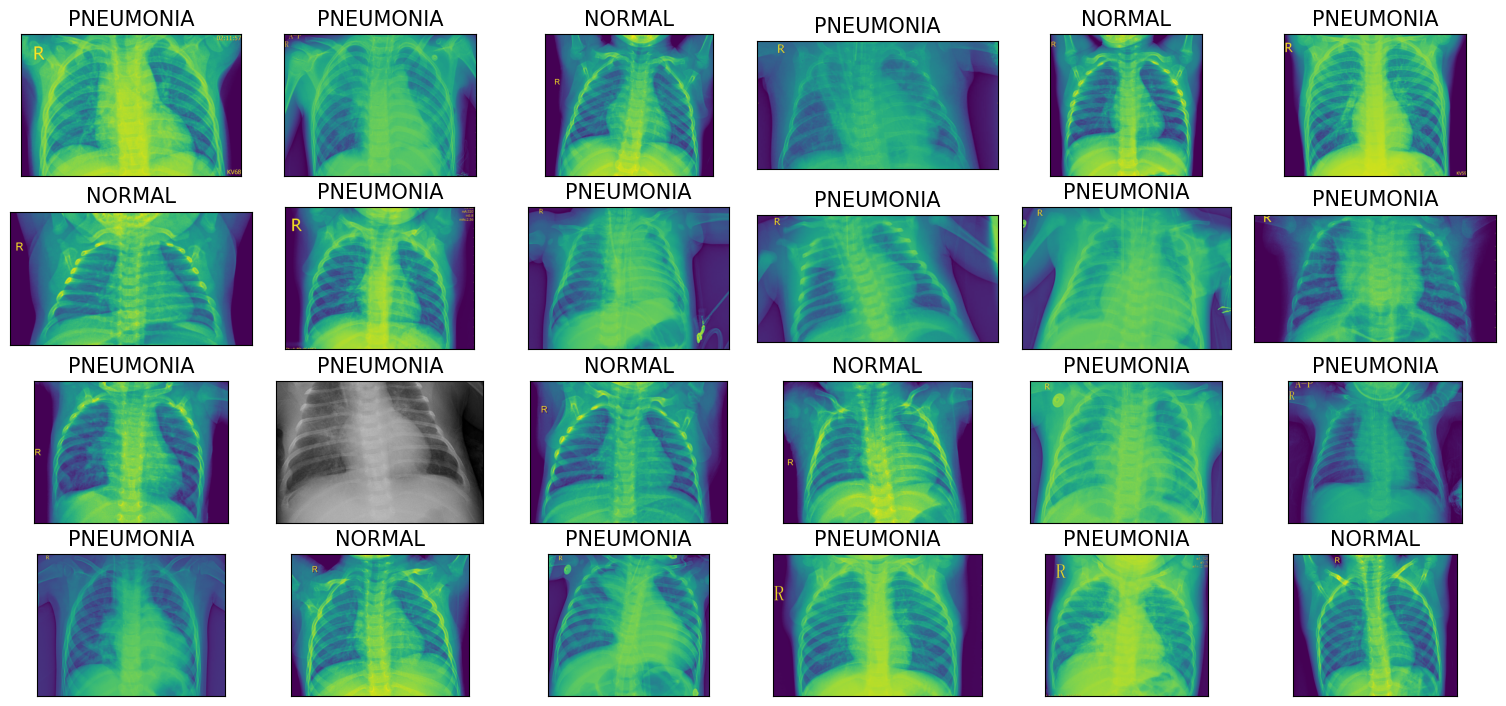

In [5]:
def display_images(df, nrows, ncols, figsize, save_path=None):
    """Displays images from the dataset on subplots and saves the generated image if save_path is provided.

    Args:
        df (pd.DataFrame): The DataFrame containing the image filepaths and labels.
        nrows (int): The number of rows of subplots.
        ncols (int): The number of columns of subplots.
        figsize (tuple): The figure size (width, height) in inches.
        save_path (str, optional): The directory to save the generated image. Defaults to None.
    """

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df.Filepath[i]))
        ax.set_title(df.Label[i], fontsize=15)

    plt.tight_layout(pad=0.5)

    # Saving the generated image if save_path is provided
    if save_path is not None:
        save_file_path = os.path.join(save_path, 'image_display.png')
        plt.savefig(save_file_path)

    plt.show()

# Example usage
display_images(train_df, nrows=4, ncols=6, figsize=(15, 7), save_path='./Images')

# 2. Load the Images with a generator and Data Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def create_gen():
    """
    Create image data generators for training, validation, and testing.

    Returns:
        train_generator (ImageDataGenerator): Image data generator for training data.
        test_generator (ImageDataGenerator): Image data generator for testing data.
        train_images (DirectoryIterator): Iterator for training images.
        val_combined_generator: Combined iterator for validation images.
        test_images (DirectoryIterator): Iterator for testing images.
    """
    # Define common image data generator arguments
    common_args = {
        'preprocessing_function': tf.keras.applications.vgg16.preprocess_input,
        'class_mode': 'categorical',
        'batch_size': 32,
        'seed': 0,
        'target_size': (224, 224)
    }

    # Define augmentation arguments
    augmentation_args = {
        'rotation_range': 30,
        'zoom_range': 0.15,
        'width_shift_range': 0.2,
        'height_shift_range': 0.2,
        'shear_range': 0.15,
        'horizontal_flip': True,
        'fill_mode': 'nearest'
    }

    # Train Data Generator with Augmentation
    train_generator = ImageDataGenerator(validation_split=0.1, **augmentation_args)

    # Validation and Test Data Generator (without Augmentation)
    val_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
    test_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

    # Flow from DataFrame arguments
    flow_args = {
        'x_col': 'Filepath',
        'y_col': 'Label',
        'color_mode': 'rgb'
    }

    # Flow from DataFrame for training images
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        subset='training',
        **common_args,
        **flow_args
    )

    # Flow from DataFrame for validation images
    # Additional validation images
    train_val_split = int(len(train_df) * 0.1)
    train_val_df = train_df.iloc[:train_val_split]

# Combine the extracted 10% with val_df
    full_val_df = pd.concat([train_val_df, val_df]).reset_index(drop=True)


# Recreate the validation generator
    val_images = train_generator.flow_from_dataframe(
        dataframe=full_val_df,
        shuffle=False,
        **common_args,
        **flow_args
    )
    # Flow from DataFrame for test images
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        shuffle=False,
        **common_args,
        **flow_args
    )

    return train_generator, test_generator, train_images,val_images, test_images

## 3. Test architectures with pre-trained weights

In [10]:
def create_model(model_class):
    """
    Create a custom model based on a model class.

    Args:
        model_class (tf.keras.Model): Model class.

    Returns:
        model (tf.keras.Model): Custom model.
    """
    # Load the pretrained model
    base_model = model_class(weights='imagenet', include_top=False, pooling='avg')
    base_model.trainable = False

    # Add custom layers on top of the base model
    x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create the custom model
    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
train_generator, test_generator, train_images, val_images, test_images = create_gen()
print('\n')

Found 4695 validated image filenames belonging to 2 classes.
Found 537 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.




In [12]:
import matplotlib.pyplot as plt

# Dictionary with the models
models = {
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "EfficientNetB0 model": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
}

# Create the generators
train_generator, test_generator, train_images, val_images, test_images = create_gen()
print('\n')

# Fit the models and collect metrics
for name, model_info in models.items():
    model = create_model(model_info['model'])
    models[name]['model'] = model

    start = perf_counter()
    history = model.fit(train_images, validation_data=val_images, epochs=20, verbose=1)
    duration = perf_counter() - start
    duration = round(duration, 2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")

    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in val_acc]



Found 4709 validated image filenames belonging to 2 classes.
Found 523 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.




c:\Users\YASHWANTHINI\Anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 2217s 15s/step - accuracy: 0.8375 - loss: 0.5315 - val_accuracy: 0.9465 - val_loss: 0.1433
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1604s 11s/step - accuracy: 0.9242 - loss: 0.1811 - val_accuracy: 0.9350 - val_loss: 0.1460
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1307s 9s/step - accuracy: 0.9374 - loss: 0.1524 - val_accuracy: 0.9426 - val_loss: 0.1402
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1191s 8s/step - accuracy: 0.9371 - loss: 0.1491 - val_accuracy: 0.9331 - val_loss: 0.1460
Epoch 5/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1091s 7s/step - accuracy: 0.9511 - loss: 0.1367 - val_accuracy: 0.9503 - val_loss: 0.1374
Epoch 6/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1313s 9s/step - accuracy: 0.9428 - loss: 0.1361 - val_accuracy: 0.9426 - val_loss: 0.1420
Epoch 7/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1260s 9s/step - accuracy: 0.9578 - loss: 0.1144 - val_accuracy: 0.9407 - val_loss: 0.1273
Epoch 8/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 1400s 9s/step - accuracy: 0.9509 - loss: 0.1257 

In [13]:
for name, model in models.items():

    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)

20/20 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step


In [14]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1],
                          models[name]['acc'],
                          models[name]['perf']])

df_results = pd.DataFrame(models_result,
                          columns = ['model','val_accuracy','accuracy (test set)','Training time (sec)'])
df_results.sort_values(by='accuracy (test set)', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
# Save df_results to a text file

df_results.to_csv('models_results.txt', index=False, sep='\t')
df_results

model  val_accuracy  accuracy (test set)  \
0  EfficientNetB0 model        0.9790               0.9151   
1                 VGG16        0.9407               0.8990   

   Training time (sec)  
0              5937.00  
1             27546.02


Model Performance Summary:
                  model  val_accuracy  accuracy (test set)  \
0  EfficientNetB0 model        0.9790               0.9151   
1                 VGG16        0.9407               0.8990   

   Training time (sec)  
0              5937.00  
1             27546.02  


C:\Users\YASHWANTHINI\AppData\Local\Temp\ipykernel_22384\648585952.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="model", y="val_accuracy", data=df_results, palette="viridis")


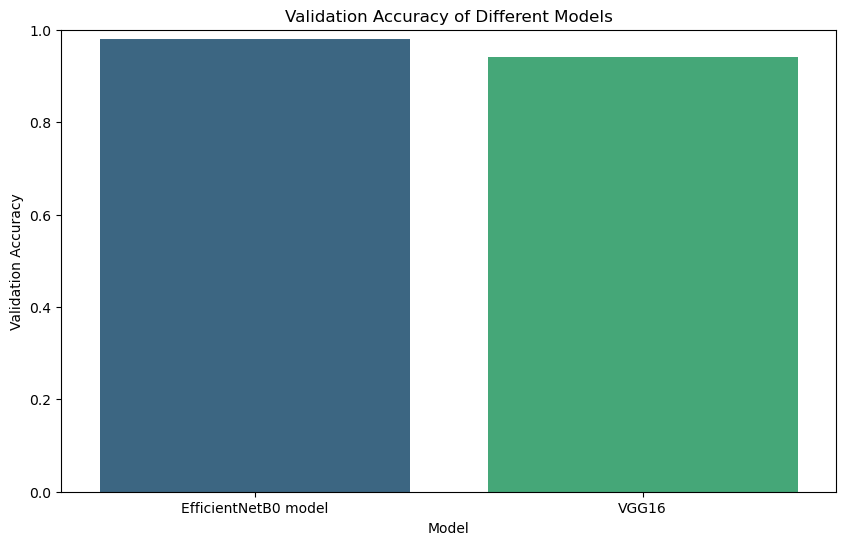

C:\Users\YASHWANTHINI\AppData\Local\Temp\ipykernel_22384\648585952.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="model", y="accuracy (test set)", data=df_results, palette="coolwarm")


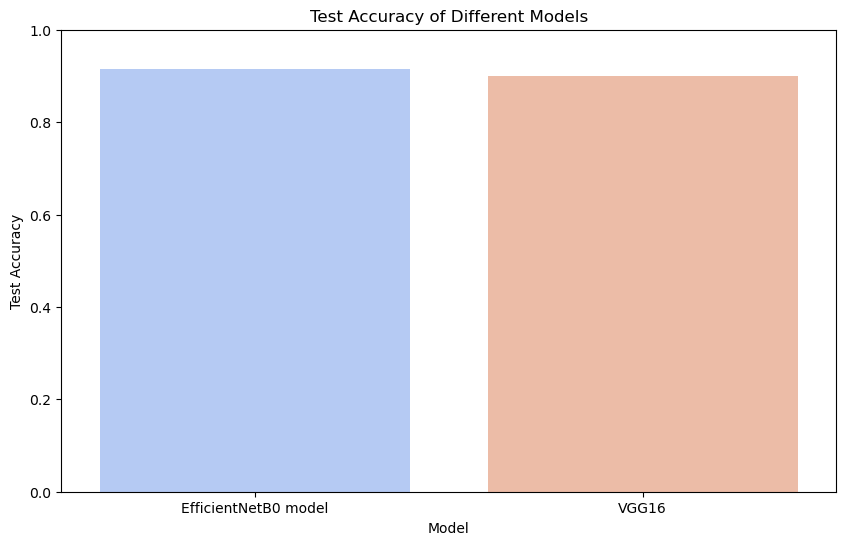

C:\Users\YASHWANTHINI\AppData\Local\Temp\ipykernel_22384\648585952.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="model", y="Training time (sec)", data=df_results, palette="magma")


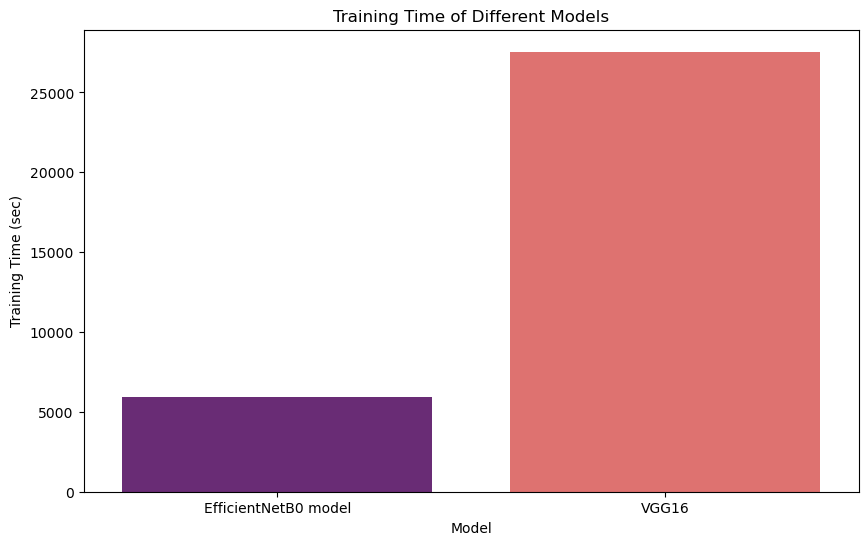

In [15]:

# Display the results
print("\nModel Performance Summary:")
print(df_results)

# Visualizing results
plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="val_accuracy", data=df_results, palette="viridis")
plt.title("Validation Accuracy of Different Models")
plt.ylabel("Validation Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="accuracy (test set)", data=df_results, palette="coolwarm")
plt.title("Test Accuracy of Different Models")
plt.ylabel("Test Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="model", y="Training time (sec)", data=df_results, palette="magma")
plt.title("Training Time of Different Models")
plt.ylabel("Training Time (sec)")
plt.xlabel("Model")
plt.show()


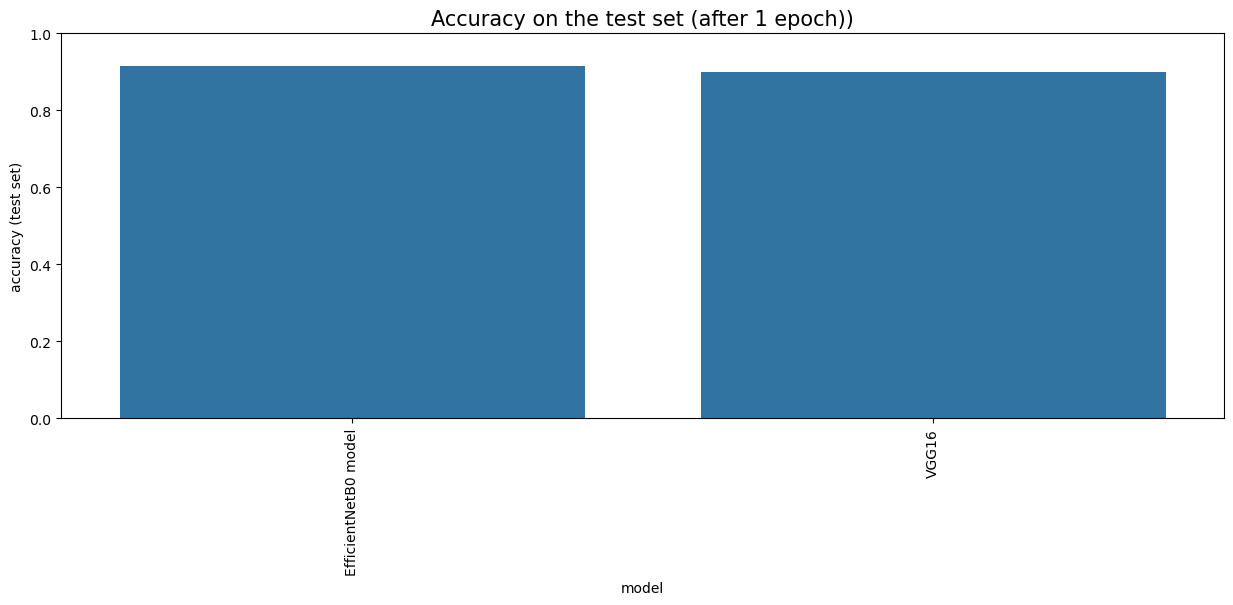

In [16]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy (test set)', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

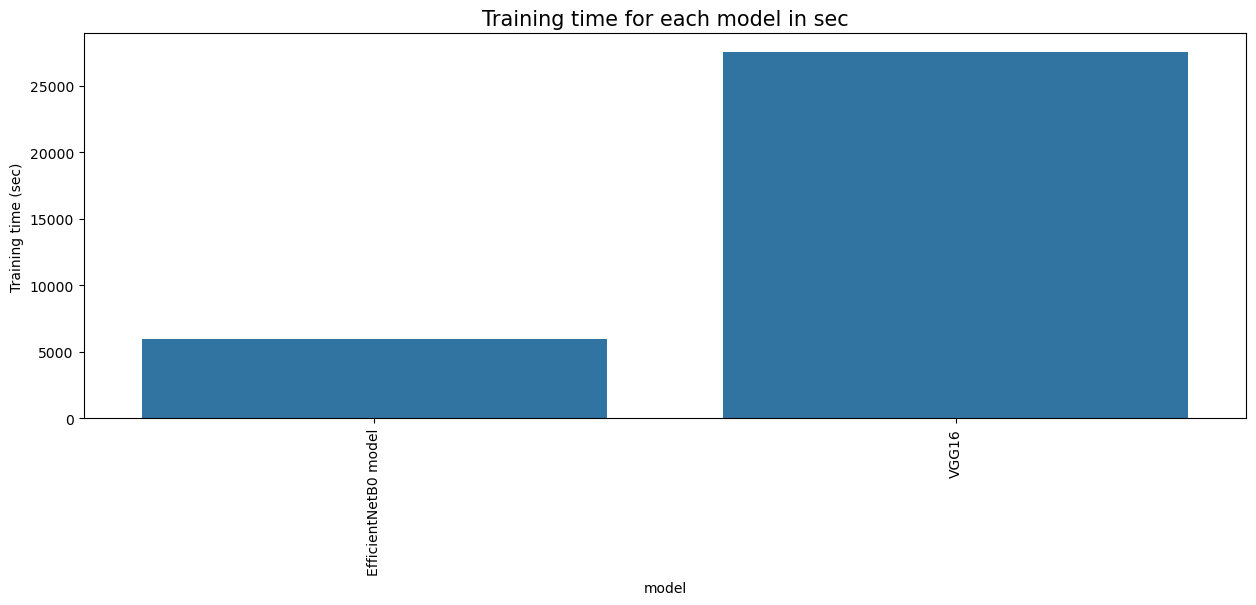

In [17]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [18]:
acc = df_results.iloc[0]['accuracy (test set)']
best_model = df_results.iloc[0]['model']
print(f'Best model: {best_model}')
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Best model: EfficientNetB0 model
Accuracy on the test set: 91.51%


In [19]:
# Save the best model
save_dir = './saved_models'
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'best_model.h5')
models[best_model]['model'].save(save_path)
print(f'Best model saved at: {save_path}')

Best model saved at: ./saved_models\best_model.h5


In [20]:
# Predict the labels of the test_images for the best model
pred = models[best_model]['model'].predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
models[name]['acc'] = round(acc,4)

20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step


Confusion matrix saved as Images/confusion_matrix.png


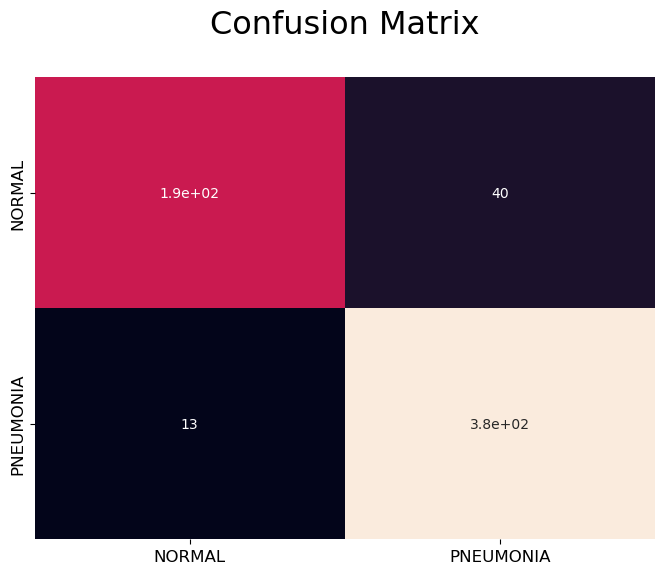

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def display_confusion_matrix(y_true, y_pred, save_path=None):
    """
    Display a confusion matrix and save it as an image file if the save_path is not None.

    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        save_path (str or None): Path to save the confusion matrix image. If None, the image will not be saved.

    Returns:
        None
    """
    cf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, xticklabels=sorted(set(y_true)), yticklabels=sorted(set(y_true)), cbar=False)
    plt.title('Confusion Matrix\n', fontsize=23)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if save_path is not None:
        plt.savefig(save_path)
        print(f"Confusion matrix saved as {save_path}")
    else:
        plt.show()
# Assuming you have the y_test and pred variables defined
save_path = "Images/confusion_matrix.png"  # Set the desired save path or set it to None to only display the matrix

display_confusion_matrix(y_test, pred, save_path)

In [22]:
from sklearn.metrics import classification_report

def save_classification_report(y_true, y_pred, save_path=None):
    """
    Print the classification report and save it as a text file if the save_path is not None.

    Args:
        y_true (list): List of true labels.
        y_pred (list): List of predicted labels.
        save_path (str or None): Path to save the classification report. If None, the report will not be saved.

    Returns:
        None
    """
    report = classification_report(y_true, y_pred)

    print(report)

    if save_path is not None:
        with open(save_path, "w") as file:
            file.write(report)
        print(f"Classification report saved as {save_path}")


# Assuming you have the y_test and pred variables defined
save_path = "classification_report.txt"  # Set the desired save path or set it to None to only print the report

save_classification_report(y_test, pred, save_path)

              precision    recall  f1-score   support

      NORMAL       0.94      0.83      0.88       234
   PNEUMONIA       0.90      0.97      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624

Classification report saved as classification_report.txt


## 5. Examples of prediction


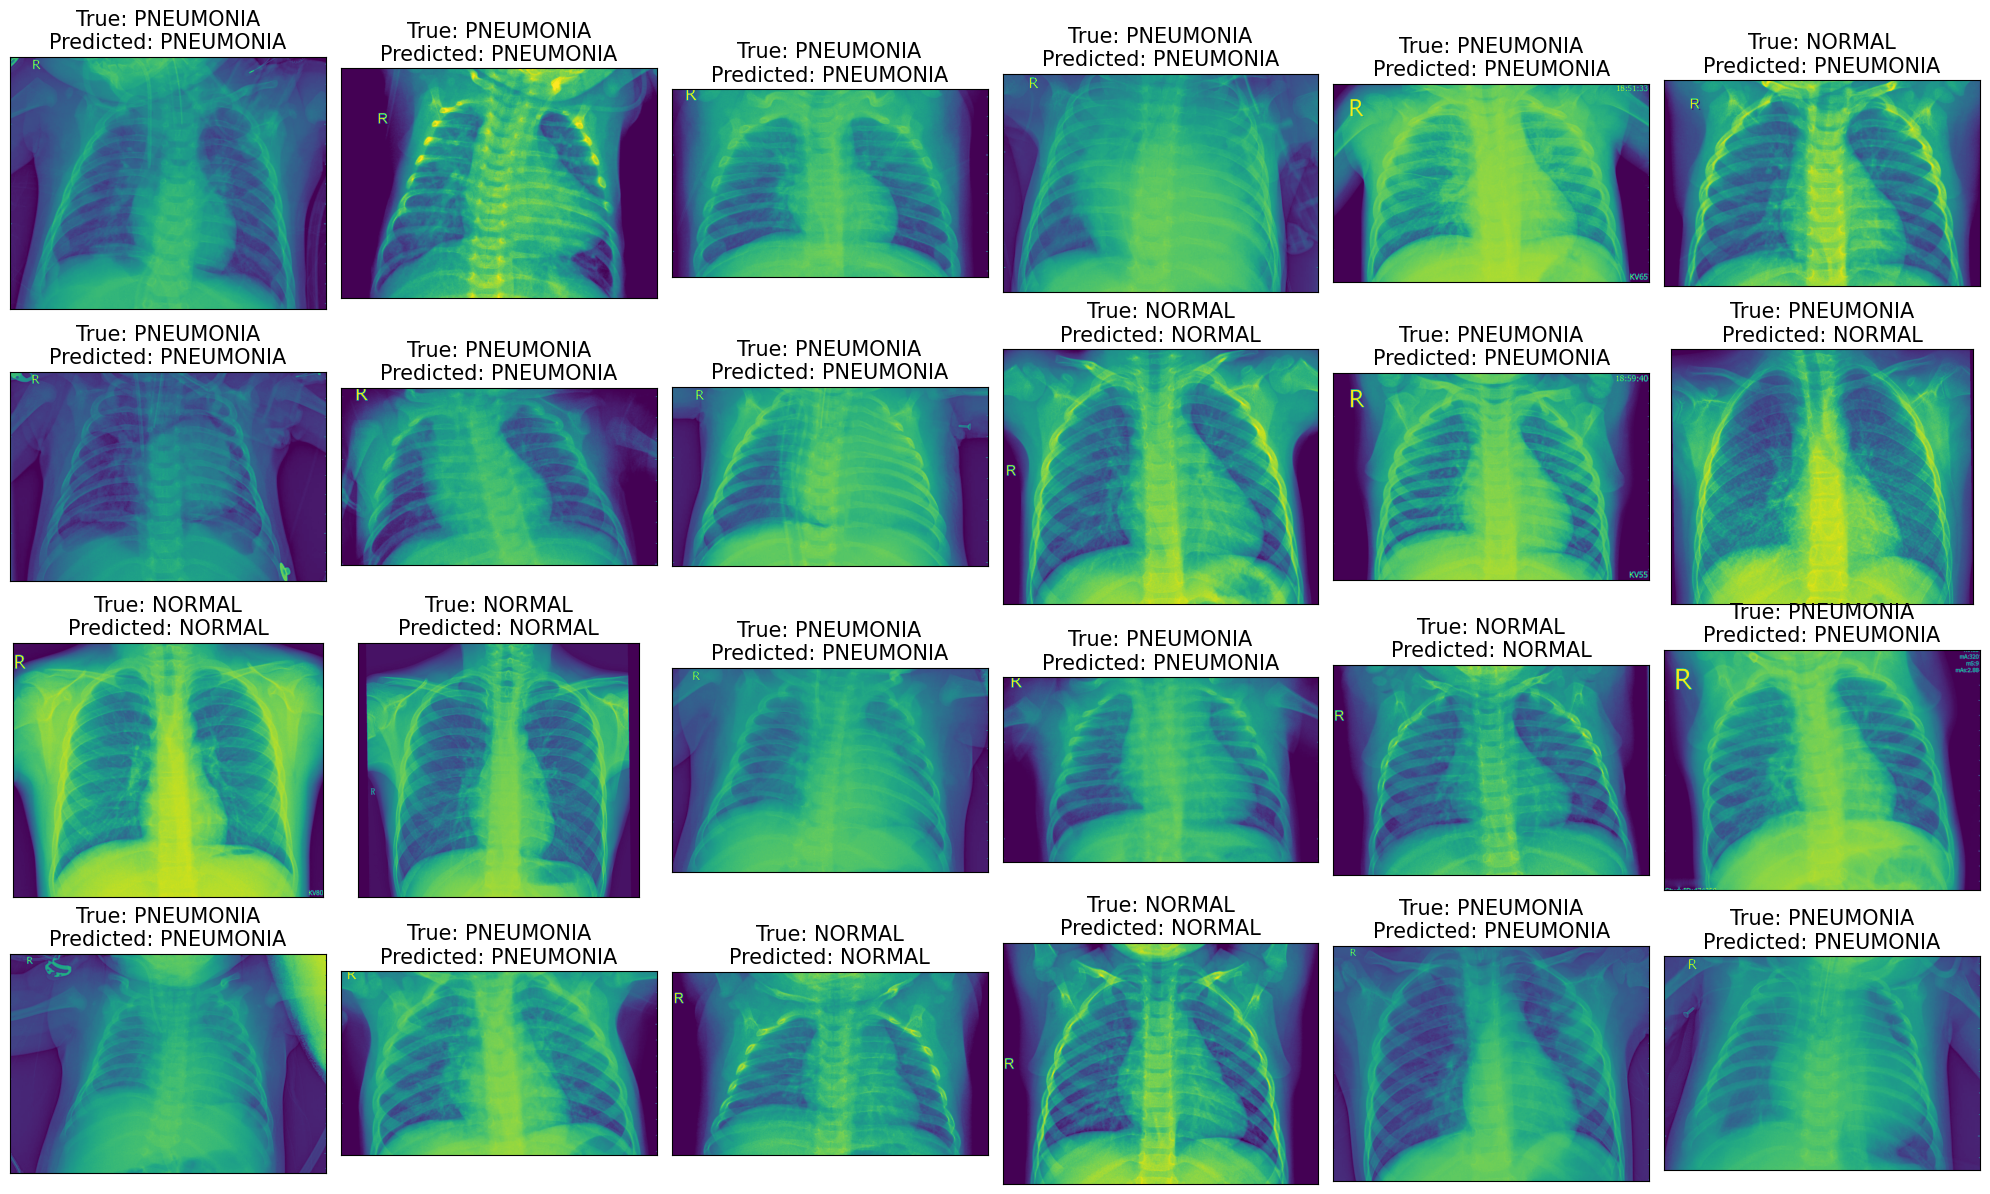

In [23]:
import matplotlib.pyplot as plt

def display_predicted_images(test_df, pred):
    """
    Display pictures of the test dataset with their True and Predicted labels.

    Args:
        test_df (pandas.DataFrame): DataFrame containing the test dataset.
        pred (list): List of predicted labels.

    Returns:
        None
    """
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
        ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}", fontsize=15)

    plt.tight_layout()
    plt.show()

display_predicted_images(test_df, pred)